In [17]:
%run resources/library.py

In [18]:
style_notebook()

# Notebook 4: Constructing Voronoi Polygons

## The `voronoi_finite_polygons_2d` function

The code below is a function to create 2d voronoi polygons given seed points. This code augments the native `Voronoi()` function in the Scipy Spatial package by closing infinite vertices.

In this case, we use the pumps as seed points.

In [19]:
%%writefile resources/voronoi2.py
# https://gist.github.com/pv/8036995
import numpy as np

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

Overwriting resources/voronoi2.py


## Load Cholera data

In [20]:
import pandas as pd

In [21]:
pumps_df = pd.read_csv('data/pumps.csv')

pumps_df

,FID,LON,LAT,Street
0,250,-0.136668,51.513341,Broadwick Street
1,251,-0.139586,51.513876,Kingly Street
2,252,-0.139671,51.514906,Ramillies Place
3,253,-0.131630,51.512354,Dean Street
4,254,-0.133594,51.512139,Rupert Street
5,255,-0.135919,51.511542,Bridle Lane
6,256,-0.133962,51.510019,Regent Street
7,257,-0.138199,51.511295,Warwick Street


In [22]:
deaths_df = pd.read_csv('data/cholera_deaths.csv')

deaths_df.head()

,FID,DEATHS,LON,LAT
0,0,3,-0.137930,51.513418
1,1,2,-0.137883,51.513361
2,2,1,-0.137853,51.513317
3,3,1,-0.137812,51.513262
4,4,4,-0.137767,51.513204


In [23]:
import numpy as np

## Create points lists (arrays) out of the Cholera data

In [24]:
points_pumps = np.array([[lon,lat] for lat,lon in pumps_df[['LAT','LON']].values])

points_pumps

array([[-0.136668, 51.513341],
       [-0.139586, 51.513876],
       [-0.139671, 51.514906],
       [-0.13163 , 51.512354],
       [-0.133594, 51.512139],
       [-0.135919, 51.511542],
       [-0.133962, 51.510019],
       [-0.138199, 51.511295]])

In [25]:
points_deaths = np.array([[lon,lat] for lat,lon in deaths_df[['LAT','LON']].values])

points_deaths

array([[-0.13793 , 51.513418],
       [-0.137883, 51.513361],
       [-0.137853, 51.513317],
       [-0.137812, 51.513262],
       [-0.137767, 51.513204],
       [-0.137537, 51.513184],
       [-0.1382  , 51.513359],
       [-0.138045, 51.513328],
       [-0.138276, 51.513323],
       [-0.138223, 51.513427],
       [-0.138337, 51.513381],
       [-0.138563, 51.513462],
       [-0.138426, 51.513216],
       [-0.138378, 51.513169],
       [-0.138337, 51.513116],
       [-0.138645, 51.51324 ],
       [-0.138698, 51.513164],
       [-0.137924, 51.513178],
       [-0.137865, 51.513111],
       [-0.137811, 51.513055],
       [-0.138762, 51.513441],
       [-0.138799, 51.513592],
       [-0.139045, 51.513402],
       [-0.13897 , 51.51338 ],
       [-0.138863, 51.513411],
       [-0.138752, 51.513641],
       [-0.138808, 51.513693],
       [-0.138856, 51.513745],
       [-0.138887, 51.513676],
       [-0.139239, 51.51359 ],
       [-0.139321, 51.513663],
       [-0.139316, 51.513502],
       [

## Create Geopandas geodataframes out of pumps and deaths data

In [26]:
from shapely.geometry import Polygon, Point, MultiPoint
import geopandas as gpd

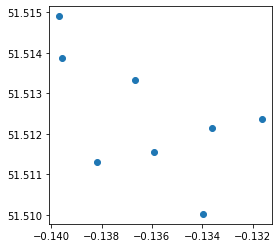

In [27]:
crs = 'EPSG:4326'
pumps_geometry = [Point(xy) for xy in zip(pumps_df.LON,pumps_df.LAT)]
pumps_gdf = gpd.GeoDataFrame(pumps_df.drop(['LON', 'LAT'], axis=1), crs=crs, geometry=pumps_geometry)

pumps_gdf.plot()

In [28]:
pumps_gdf

,FID,Street,geometry
0,250,Broadwick Street,POINT (-0.13667 51.51334)
1,251,Kingly Street,POINT (-0.13959 51.51388)
2,252,Ramillies Place,POINT (-0.13967 51.51491)
3,253,Dean Street,POINT (-0.13163 51.51235)
4,254,Rupert Street,POINT (-0.13359 51.51214)
5,255,Bridle Lane,POINT (-0.13592 51.51154)
6,256,Regent Street,POINT (-0.13396 51.51002)
7,257,Warwick Street,POINT (-0.13820 51.51130)


### Save the geodataframes to Shapefile and JSON format

In [29]:
pumps_gdf.to_file('outputs/pumps.shp')
pumps_gdf.to_file("outputs/pumps.json", driver="GeoJSON")

2020-07-04 22:34:48,994 [5607] ERROR    fiona._env:157: [JupyterRequire] outputs/pumps.json: No such file or directory
2020-07-04 22:34:48,994 [5607] WARNING  fiona._env:157: [JupyterRequire] driver GeoJSON does not support creation option ENCODING


### Quick plots of geodataframes

In [30]:
import matplotlib.pyplot as plt

%matplotlib inline

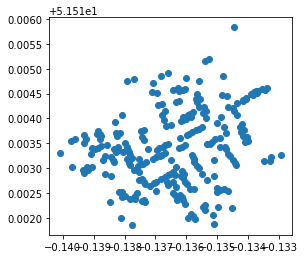

In [32]:
crs = 'EPSG:4326'
deaths_geometry = [Point(xy) for xy in zip(deaths_df.LON, deaths_df.LAT)]
deaths_gdf = gpd.GeoDataFrame(deaths_df.drop(['LON', 'LAT'], axis=1), \
                              crs=crs, geometry=deaths_geometry)

deaths_gdf.plot()

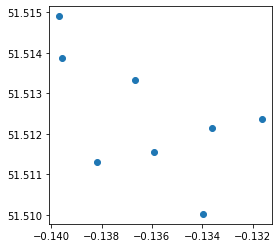

In [33]:
pumps_gdf.plot()

### Save the geodataframes to Shapefile and JSON format

In [34]:
deaths_gdf.to_file('outputs/deaths.shp')
deaths_gdf.to_file("outputs/deaths.json", driver="GeoJSON")

2020-07-04 22:35:12,313 [5607] ERROR    fiona._env:157: [JupyterRequire] outputs/deaths.json: No such file or directory
2020-07-04 22:35:12,314 [5607] WARNING  fiona._env:157: [JupyterRequire] driver GeoJSON does not support creation option ENCODING


## Compute Voronoi polygons

In [35]:
from scipy.spatial import Voronoi

Let's run the voronoi 2d generation Python file that we saved earlier.

In [36]:
%run resources/voronoi2.py

<Figure size 432x288 with 0 Axes>

In [37]:
# compute Voronoi tesselation using scipy spatial Voronoi function
# note: this function does not create regions (polygons) for infinite vertices
vor = Voronoi(points_pumps)

# compute 2d voronoi with finite polygons
regions, vertices = voronoi_finite_polygons_2d(vor)

# display regions (polygon indices to vertices)
regions

[[8, 4, 3, 0, 2, 6],
 [10, 4, 3, 9],
 [12, 3, 0, 11],
 [0, 2, 1, 14, 13],
 [6, 2, 1, 5],
 [8, 6, 5, 7],
 [16, 15, 1, 5, 7],
 [17, 18, 7, 8, 4]]

In [38]:
# display voronoi polygon vertices (all of them)
# note: these have to be used with regions where the indices point to each vertex in this list
vertices

array([[-1.31326612e-01,  5.15272540e+01],
       [-1.32459132e-01,  5.15108501e+01],
       [-1.33205177e-01,  5.15176651e+01],
       [-1.37958261e-01,  5.15145288e+01],
       [-1.38251395e-01,  5.15129300e+01],
       [-1.34597493e-01,  5.15112213e+01],
       [-1.35044362e-01,  5.15129616e+01],
       [-1.36739460e-01,  5.15084689e+01],
       [-1.37132005e-01,  5.15120924e+01],
       [-1.03097118e+02,  4.30178991e+01],
       [-9.11397016e+01,  2.60978730e+00],
       [ 3.11200978e+01,  1.49996182e+02],
       [-1.03097118e+02,  4.30178991e+01],
       [ 3.11200978e+01,  1.49996182e+02],
       [ 7.29650869e+01, -2.14927805e+01],
       [ 7.29650869e+01, -2.14927805e+01],
       [-2.99273435e+01, -4.74122125e+01],
       [-9.11397016e+01,  2.60978730e+00],
       [-2.99273435e+01, -4.74122125e+01]])

In [39]:
# voronoi input points (pump locations) from the original scipy spatial Voronoi function
vor.points

array([[-0.136668, 51.513341],
       [-0.139586, 51.513876],
       [-0.139671, 51.514906],
       [-0.13163 , 51.512354],
       [-0.133594, 51.512139],
       [-0.135919, 51.511542],
       [-0.133962, 51.510019],
       [-0.138199, 51.511295]])

## Store Voronoi polygons in a Geopandas geodataframe

In [45]:
# create an empty geodataframe
# set empty geodataframe CRS to EPSG 4326
crs = 'EPSG:4326'
vor_poly_gdf1 = gpd.GeoDataFrame(crs=crs)

vor_poly_gdf1

""


That's what an empty geodataframe looks like!

In [46]:
# initialize index
index = 0

for region in regions:
    
    # print vertices for each region (voronoi polygon)
    #print(vertices[region])
    
    # convert each polygon into Shapely Polygon
    vor_poly = Polygon(vertices[region])
    
    # save Polygon as geopandas geometry column
    vor_poly_gdf1.loc[index, 'geometry'] = vor_poly
    
    # display corresponding vor input point (pump location: lat, lon)
    vorpoint_lat = vor.points[index][1]
    vorpoint_lon = vor.points[index][0]
    #print("vor.point:", vorpoint_lat, vorpoint_lon)
    
    # save lat, lon to geopandas geodataframe
    vor_poly_gdf1.loc[index, 'vorpoint_lat'] = vorpoint_lat
    vor_poly_gdf1.loc[index, 'vorpoint_lon'] = vorpoint_lon

    # increment index by 1
    index = index + 1

In [48]:
vor_poly_gdf1.crs = 'EPSG:4326'

In [49]:
vor_poly_gdf1

,geometry,vorpoint_lat,vorpoint_lon
0,"POLYGON ((-0.137 51.512, -0.138 51.513, -0.138...",51.513341,-0.136668
1,"POLYGON ((-91.140 2.610, -0.138 51.513, -0.138...",51.513876,-0.139586
2,"POLYGON ((-103.097 43.018, -0.138 51.515, -0.1...",51.514906,-0.139671
3,"POLYGON ((-0.131 51.527, -0.133 51.518, -0.132...",51.512354,-0.131630
4,"POLYGON ((-0.135 51.513, -0.133 51.518, -0.132...",51.512139,-0.133594
5,"POLYGON ((-0.137 51.512, -0.135 51.513, -0.135...",51.511542,-0.135919
6,"POLYGON ((-29.927 -47.412, 72.965 -21.493, -0....",51.510019,-0.133962
7,"POLYGON ((-91.140 2.610, -29.927 -47.412, -0.1...",51.511295,-0.138199


## Quick plot of the Voronoi polygons using Geopandas

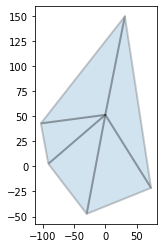

In [50]:
vor_poly_gdf1.plot(alpha=0.2, edgecolor='black', linewidth=2)

Note how the latitude and longitude values would mean a folium plot of the voronoi cells would extend far beyond the viewing window of a web map.

## Geopandas spatial join - pumps and Voronoi polygons

In [51]:
# do a geopandas spatial join (intersection)
# this assumes pump locations in geometry column are within (intersects with) voronoi polygon
vor_poly_gdf2 = \
    gpd.sjoin(vor_poly_gdf1, pumps_gdf, how="inner", op='intersects')\
    .drop(columns=['index_right'])

vor_poly_gdf2

,geometry,vorpoint_lat,vorpoint_lon,FID,Street
0,"POLYGON ((-0.137 51.512, -0.138 51.513, -0.138...",51.513341,-0.136668,250,Broadwick Street
1,"POLYGON ((-91.140 2.610, -0.138 51.513, -0.138...",51.513876,-0.139586,251,Kingly Street
2,"POLYGON ((-103.097 43.018, -0.138 51.515, -0.1...",51.514906,-0.139671,252,Ramillies Place
3,"POLYGON ((-0.131 51.527, -0.133 51.518, -0.132...",51.512354,-0.131630,253,Dean Street
4,"POLYGON ((-0.135 51.513, -0.133 51.518, -0.132...",51.512139,-0.133594,254,Rupert Street
5,"POLYGON ((-0.137 51.512, -0.135 51.513, -0.135...",51.511542,-0.135919,255,Bridle Lane
6,"POLYGON ((-29.927 -47.412, 72.965 -21.493, -0....",51.510019,-0.133962,256,Regent Street
7,"POLYGON ((-91.140 2.610, -29.927 -47.412, -0.1...",51.511295,-0.138199,257,Warwick Street


Getting warmer...

## Clipping the Voronoi polygons

The polygons above will extend beyond screen if plotted on a `folium` map. We will clip the voronoi polygons that extend beyond the convex hull that we created earlier in Notebook 2. Code follows below.

### Retrieve the convex hull polygon we created earlier in Notebook 2

In [52]:
convexhull_gdf = gpd.read_file('outputs/convexhull.shp')

### Use Geopandas overlay to obtain the intersection of Voronoi polygons with the convex hull polygon [1]

In [53]:
clipped_voronoi_gdf = gpd.overlay(
    convexhull_gdf,
    vor_poly_gdf2,
    how="intersection"
).drop(columns=['FID_1']).rename(columns={'FID_2':'FID'})

clipped_voronoi_gdf

,vorpoint_lat,vorpoint_lon,FID,Street,geometry
0,51.513341,-0.136668,250,Broadwick Street,"POLYGON ((-0.13640 51.51752, -0.13483 51.51780..."
1,51.513876,-0.139586,251,Kingly Street,"POLYGON ((-0.14106 51.51142, -0.14153 51.51193..."
2,51.514906,-0.139671,252,Ramillies Place,"POLYGON ((-0.14191 51.51420, -0.14161 51.51539..."
3,51.512354,-0.131630,253,Dean Street,"POLYGON ((-0.13006 51.51359, -0.12994 51.51343..."
4,51.512139,-0.133594,254,Rupert Street,"POLYGON ((-0.13329 51.51745, -0.13327 51.51743..."
5,51.511542,-0.135919,255,Bridle Lane,"POLYGON ((-0.13655 51.50871, -0.13677 51.50878..."
6,51.510019,-0.133962,256,Regent Street,"POLYGON ((-0.13138 51.50977, -0.13255 51.50861..."
7,51.511295,-0.138199,257,Warwick Street,"POLYGON ((-0.13677 51.50878, -0.13878 51.50938..."


### Quick plot of the clipped Voronoi polygons

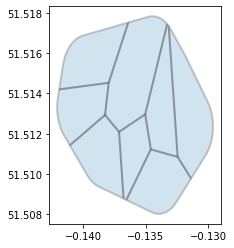

In [54]:
clipped_voronoi_gdf.plot(alpha=0.2, edgecolor='black',linewidth=2)

That looks very promising...

Now, let's put the two plots together - the unclipped voronoi cells and the clipped ones. Here's a simple `matplotlib` plotting lesson below. We defined `matplotlib.pyplot` earlier as `plt`.

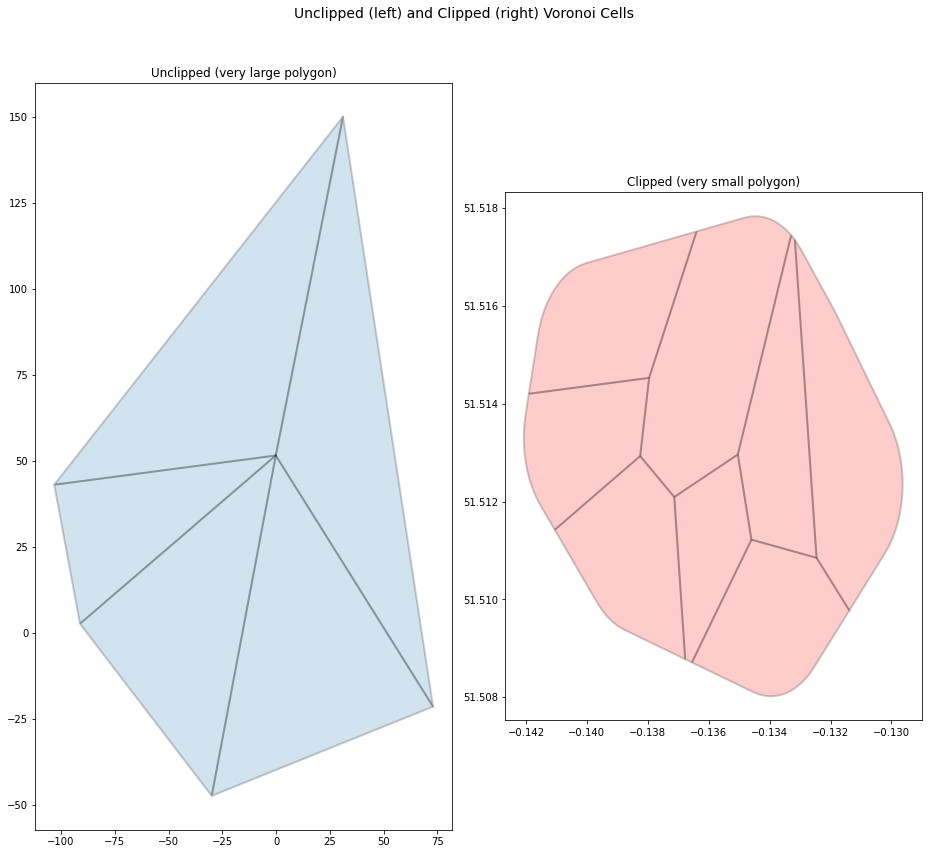

In [55]:
# note how we create subplots side by side using subplot parameters, nrows and ncols
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 13))

# here are the two plots
# since we used two columns, column 1 uses axes[0] and column 2 uses axes[1]
vor_poly_gdf1.plot(alpha=0.2, edgecolor='black',linewidth=2, \
                   ax=axes[0])
clipped_voronoi_gdf.plot(alpha=0.2, edgecolor='black',linewidth=2, 
                         ax=axes[1], color='red')

# let's put the titles so we will know what we are looking at
fig.suptitle("Unclipped (left) and Clipped (right) Voronoi Cells", fontsize=14)
axes[0].set_title("Unclipped (very large polygon)")
axes[1].set_title("Clipped (very small polygon)")

fig.tight_layout()

Note that the two figures are not the same size and scale.

### Save the clipped Voronoi polygons

In [56]:
clipped_voronoi_gdf.to_file('outputs/clipped_voronoi.shp')
clipped_voronoi_gdf.to_file("outputs/clipped_voronoi.json", driver="GeoJSON")

2020-07-04 22:36:52,846 [5607] WARNING  fiona._env:157: [JupyterRequire] Normalized/laundered field name: 'vorpoint_lat' to 'vorpoint_l'
2020-07-04 22:36:52,848 [5607] WARNING  fiona._env:157: [JupyterRequire] Normalized/laundered field name: 'vorpoint_lon' to 'vorpoint_1'
2020-07-04 22:36:52,863 [5607] ERROR    fiona._env:157: [JupyterRequire] outputs/clipped_voronoi.json: No such file or directory
2020-07-04 22:36:52,864 [5607] WARNING  fiona._env:157: [JupyterRequire] driver GeoJSON does not support creation option ENCODING


In [57]:
clipped_voronoi_gdf

,vorpoint_lat,vorpoint_lon,FID,Street,geometry
0,51.513341,-0.136668,250,Broadwick Street,"POLYGON ((-0.13640 51.51752, -0.13483 51.51780..."
1,51.513876,-0.139586,251,Kingly Street,"POLYGON ((-0.14106 51.51142, -0.14153 51.51193..."
2,51.514906,-0.139671,252,Ramillies Place,"POLYGON ((-0.14191 51.51420, -0.14161 51.51539..."
3,51.512354,-0.131630,253,Dean Street,"POLYGON ((-0.13006 51.51359, -0.12994 51.51343..."
4,51.512139,-0.133594,254,Rupert Street,"POLYGON ((-0.13329 51.51745, -0.13327 51.51743..."
5,51.511542,-0.135919,255,Bridle Lane,"POLYGON ((-0.13655 51.50871, -0.13677 51.50878..."
6,51.510019,-0.133962,256,Regent Street,"POLYGON ((-0.13138 51.50977, -0.13255 51.50861..."
7,51.511295,-0.138199,257,Warwick Street,"POLYGON ((-0.13677 51.50878, -0.13878 51.50938..."


## Counting Death Locations Within Voronoi Polygons [2]

One of the most important things to study in this case is to determine which Voronoi polygon contains the most number of death locations. 

In [58]:
# Read the data.
polygons = gpd.GeoDataFrame.from_file('outputs/clipped_voronoi.shp')
points = gpd.GeoDataFrame.from_file('outputs/deaths.shp')

Let's write the function, `points_in_polygons` below to a Python file as we will use this again in Notebook 6.

In [59]:
%%writefile resources/points_in_polygons.py
import geopandas as gpd
import pandas as pd

def points_in_polygons(points_gdf, polygons_gdf):
    
    polygons = polygons_gdf
    points = points_gdf
    
    # Make a copy because I'm going to drop points as I
    # assign them to polys, to speed up subsequent search.
    pts = points.copy() 

    # We're going to keep a list of how many points we find.
    pts_in_polys = []

    # Loop over polygons with index i.
    for i, poly in polygons.iterrows():

        # Keep a list of points in this poly
        pts_in_this_poly = []

        # Now loop over all points with index j.
        for j, pt in pts.iterrows():
            if poly.geometry.contains(pt.geometry):
                # Then it's a hit! Add it to the list,
                # and drop it so we have less hunting.
                pts_in_this_poly.append(pt.geometry)
                pts = pts.drop([j])

        # We could do all sorts, like grab a property of the
        # points, but let's just append the number of them.
        pts_in_polys.append(len(pts_in_this_poly))

    # Add the number of points for each poly to the dataframe.
    polygons['points_in_polygon'] = gpd.GeoSeries(pts_in_polys)
    
    return polygons

Overwriting resources/points_in_polygons.py


In [60]:
%run resources/points_in_polygons.py

<Figure size 432x288 with 0 Axes>

In [61]:
polygons = points_in_polygons(points, polygons)

polygons

,vorpoint_l,vorpoint_1,FID,Street,geometry,points_in_polygon
0,51.513341,-0.136668,250,Broadwick Street,"POLYGON ((-0.13640 51.51752, -0.13483 51.51780...",137
1,51.513876,-0.139586,251,Kingly Street,"POLYGON ((-0.14106 51.51142, -0.14153 51.51193...",38
2,51.514906,-0.139671,252,Ramillies Place,"POLYGON ((-0.14191 51.51420, -0.14161 51.51539...",1
3,51.512354,-0.131630,253,Dean Street,"POLYGON ((-0.13006 51.51359, -0.12994 51.51343...",0
4,51.512139,-0.133594,254,Rupert Street,"POLYGON ((-0.13329 51.51745, -0.13327 51.51743...",41
5,51.511542,-0.135919,255,Bridle Lane,"POLYGON ((-0.13655 51.50871, -0.13677 51.50878...",21
6,51.510019,-0.133962,256,Regent Street,"POLYGON ((-0.13138 51.50977, -0.13255 51.50861...",0
7,51.511295,-0.138199,257,Warwick Street,"POLYGON ((-0.13677 51.50878, -0.13878 51.50938...",12


### Let's fix the column names  of the geodataframe holding the Voronoi cells with counts

In [62]:
clipped_voronoi_counts_gdf = \
    polygons.rename(\
            columns={'vorpoint_l':'vorpoint_lat',\
                     'vorpoint_1':'vorpoint_lon',\
                     'points_in_polygon':'points_in_voronoi'
                    })

clipped_voronoi_counts_gdf

,vorpoint_lat,vorpoint_lon,FID,Street,geometry,points_in_voronoi
0,51.513341,-0.136668,250,Broadwick Street,"POLYGON ((-0.13640 51.51752, -0.13483 51.51780...",137
1,51.513876,-0.139586,251,Kingly Street,"POLYGON ((-0.14106 51.51142, -0.14153 51.51193...",38
2,51.514906,-0.139671,252,Ramillies Place,"POLYGON ((-0.14191 51.51420, -0.14161 51.51539...",1
3,51.512354,-0.131630,253,Dean Street,"POLYGON ((-0.13006 51.51359, -0.12994 51.51343...",0
4,51.512139,-0.133594,254,Rupert Street,"POLYGON ((-0.13329 51.51745, -0.13327 51.51743...",41
5,51.511542,-0.135919,255,Bridle Lane,"POLYGON ((-0.13655 51.50871, -0.13677 51.50878...",21
6,51.510019,-0.133962,256,Regent Street,"POLYGON ((-0.13138 51.50977, -0.13255 51.50861...",0
7,51.511295,-0.138199,257,Warwick Street,"POLYGON ((-0.13677 51.50878, -0.13878 51.50938...",12


### Save the clipped Voronoi polygons with death location counts

In [63]:
clipped_voronoi_counts_gdf.to_file('outputs/clipped_voronoi_counts.shp')
clipped_voronoi_counts_gdf.to_file("outputs/clipped_voronoi_counts.json", driver="GeoJSON")

2020-07-04 22:37:01,720 [5607] WARNING  fiona._env:157: [JupyterRequire] Normalized/laundered field name: 'vorpoint_lat' to 'vorpoint_l'
2020-07-04 22:37:01,721 [5607] WARNING  fiona._env:157: [JupyterRequire] Normalized/laundered field name: 'vorpoint_lon' to 'vorpoint_1'
2020-07-04 22:37:01,722 [5607] WARNING  fiona._env:157: [JupyterRequire] Normalized/laundered field name: 'points_in_voronoi' to 'points_in_'
2020-07-04 22:37:01,739 [5607] ERROR    fiona._env:157: [JupyterRequire] outputs/clipped_voronoi_counts.json: No such file or directory
2020-07-04 22:37:01,740 [5607] WARNING  fiona._env:157: [JupyterRequire] driver GeoJSON does not support creation option ENCODING


## And now, for amplified cognition - Draw a simple horizontal bar chart

### Horizontal Bar Showing Death Locations by Voronoi Cells (Pump Catchment)

Text(0.5, 0, 'Death Location Count')

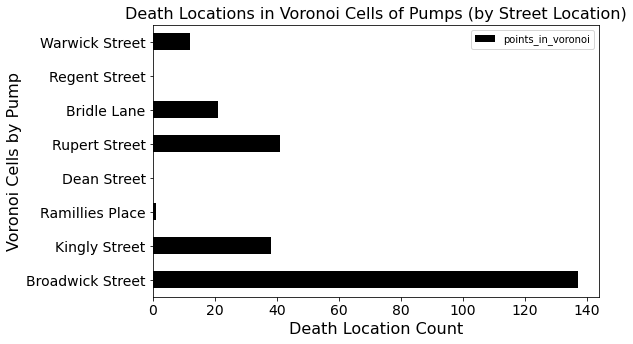

In [64]:
ax = pd.DataFrame(clipped_voronoi_counts_gdf)\
    .plot.barh(y='points_in_voronoi', x='Street', color='k', figsize=(8,5))
ax.set_title('Death Locations in Voronoi Cells of Pumps (by Street Location)', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_ylabel('Voronoi Cells by Pump', fontsize=16)
ax.set_xlabel('Death Location Count', fontsize=16)

Which street pump catchment area (Voronoi cell) has the most number of mortality locations?

### Draft Map Overlaying Pumps, Death Locations and Voronoi Cells

Text(0.5, 1.0, 'Deaths Locations within Pump-derived Voronoi Cells, Soho District')

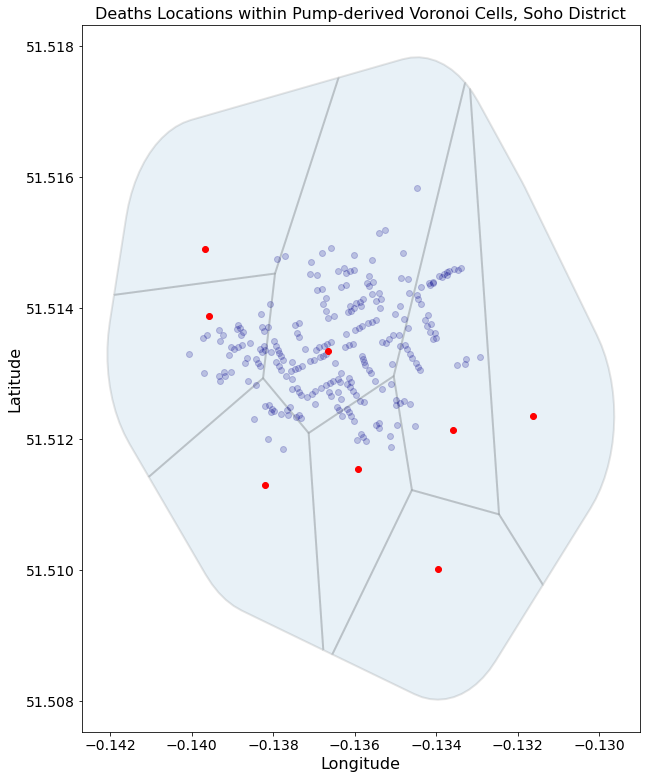

In [65]:
width = 13
height = 13

fig, ax = plt.subplots(figsize=(width, height))

# putting together the three plots
clipped_voronoi_gdf.plot(ax=ax, alpha=0.1, edgecolor='black',linewidth=2)
deaths_gdf.plot(ax=ax, alpha=0.2, color='darkblue')
pumps_gdf.plot(ax=ax,color='red')

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
# always good to remember, x maps to longitude, y maps to latitude 
ax.set_ylabel('Latitude', fontsize=16)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_title('Deaths Locations within Pump-derived Voronoi Cells, Soho District', \
             fontsize=16)

## Reflection Questions

1. What did you learn from going through the Voronoi production code from Notebooks 2-4?
2. What else can we do to improve our Voronoi production process?

## References

1. How to use geopandas' overlay method to find the area of intersections between two datasets: https://github.com/datadesk/geopandas-intersection-area-example
2. Count number of points in multipolygon shapefile using Python: https://stackoverflow.com/questions/27606924/count-number-of-points-in-multipolygon-shapefile-using-python